<a href="https://colab.research.google.com/github/pratyushprasad2323/tensors/blob/main/A4_tensors_gradient_and_auto_differentiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## INTRODUCTION TO GRADIENTS AND AUTOMATIC DIFFERENTIATION

auto differentiation is useful in implementing ML algo such as back propagation for training NN.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## COMPUTING GRADIENTS

to differentiate automatically, TF needs to remember what operations happen in what order during the forward pass. then during the backward pass TF traverses this list of operations in reverse order to compute gradients.

## GRADIENT TAPES

tf.GradientTape is used for automatic differentiation(AD). computing the gradient of a computation with respect to some inputs, usually tf.Variables. TF records relevant operations executed inside the context of a tf.GradientTape onto a tape. it then uses that tape to compute the gradients of a recorded computation using reverse mode differentiation.

In [2]:
x=tf.Variable(10,dtype='float32')
with tf.GradientTape() as tape:
  y=x**2-3*x+2
diff=tape.gradient(y,x)
print(diff.numpy())  

17.0


In [3]:
a=tf.Variable(tf.random.normal((3,2)),name='w')
print(a)
b=tf.Variable(tf.zeros(2,dtype=tf.float32),name='b')
x=[[1.,2.,3.]]
with tf.GradientTape(persistent=True) as tape:
  y=x@a+b
  print('hi')
  print(y)
  loss=tf.reduce_mean(y**2)
x,y=tape.gradient(loss,[a,b])
print(x)

<tf.Variable 'w:0' shape=(3, 2) dtype=float32, numpy=
array([[-0.8288095 , -1.3020223 ],
       [-1.2617884 , -1.7088464 ],
       [-1.1983337 ,  0.06671695]], dtype=float32)>
hi
tf.Tensor([[-6.9473877 -4.519564 ]], shape=(1, 2), dtype=float32)
tf.Tensor(
[[ -6.947387  -4.519564]
 [-13.894774  -9.039128]
 [-20.842161 -13.558693]], shape=(3, 2), dtype=float32)


## GRADIENT WITH RESPECT TO A MODEL

In [4]:
layer=tf.keras.layers.Dense(2,activation='relu')
x=tf.constant([[1.,2.,3.]])
with tf.GradientTape() as tape:
  # Forward pass
  y=layer(x)
  loss=tf.reduce_mean(y**2)

# Calculate gradients with respect to every trainable variable
grad=tape.gradient(loss, layer.trainable_variables)
print(grad)

for var,g in zip(layer.trainable_variables,grad):
  print(f'{var.name}, shape: {g.shape}')

[<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>]
dense/kernel:0, shape: (3, 2)
dense/bias:0, shape: (2,)


## CONTROLLING WHAT THE TPE WATCHES

the taape must know which operation to record in the forward pass . it holds reference to intermediate outputs by which unnecessary data is not recorded. the most common case involves calculating the gradient of a loss wrt all models trainable variable.

In [5]:
x0=tf.Variable(3.0)                     # x0 is a trainable variable
x1=tf.Variable(3.0,trainable=False)     # x1 is not a trainable variable
x2=tf.Variable(2.0)+1.0                 # x2 is not a variable
x3=tf.constant(3.0)                     # x3 is a constant
with tf.GradientTape() as tape:
  y=(x0**2)+(x1**2)+(x2**2)
grad=tape.gradient(y,[x0,x1,x2,x3])

for g in grad:
  print(g)

# the variable that is being watched
print([var.name for var in tape.watched_variables()])

tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None
['Variable:0']


In [6]:
# controlling what variable to watch
x0=tf.Variable(3.141)
x1=tf.Variable(1.414)

with tf.GradientTape(watch_accessed_variables=False) as tape:
  tape.watch(x1)
  y0=tf.math.sin(x0)
  y1=tf.nn.softplus(x1)
  y=y0+y1
  ys=tf.reduce_sum(y)
grad=tape.gradient(ys,{'x0':x0,'x1':x1})
print(grad['x0'])
print(grad['x1'])

None
tf.Tensor(0.80439615, shape=(), dtype=float32)


In [7]:
# some more examples
x=tf.Variable(2.0)
with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  y=x**2
  z=y**2
print(tape.gradient(z,y).numpy())
print(tape.gradient(y,x).numpy())
print(tape.gradient(z,x).numpy())

8.0
4.0
32.0


## PERFORMANCE OF CODE

for less complexity of code the execution will not be a niticable cost

Gradient tapes use memory to store intermediate results, including inputs and outputs, for use during the backwards pass.

for efficiency, some operations don't need to keep their intermediate results and they are pruned during the forward pass. However, if you use persistent=True on your tape, nothing is discarded and your peak memory usage will be higher.

In [8]:
x=tf.Variable(5.0)
with tf.GradientTape(persistent=True) as tape:
  y0=x**3
  y1=1/x
print(tape.gradient(y0,x))
print(tape.gradient(y1,x))
print(tape.gradient({'y0':y0,'y1':y1},x).numpy())       # finds the sum of both result

tf.Tensor(74.99999, shape=(), dtype=float32)
tf.Tensor(-0.04, shape=(), dtype=float32)
74.95999


In [9]:
x=tf.Variable(5.0)
with tf.GradientTape(persistent=True) as tape:
  y0=x*[2.0+3.0]
print(tape.gradient(y0,x))

tf.Tensor(5.0, shape=(), dtype=float32)


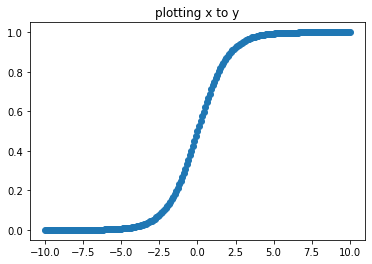

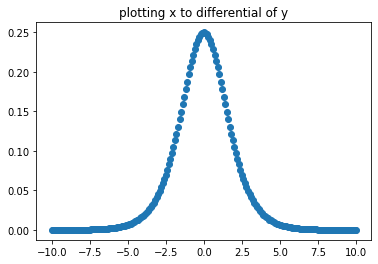

In [10]:
x=tf.linspace(-10,10,201)
with tf.GradientTape() as tape:
  tape.watch(x)
  y=tf.nn.sigmoid(x)
y_diff=tape.gradient(y,x)

plt.plot(x,y,'o')
plt.title('plotting x to y')
plt.show()

plt.plot(x,y_diff,'o')
plt.title('plotting x to differential of y')
plt.show()

In [11]:
x=tf.constant(1.0)
v0=tf.Variable(2.0)
v1=tf.Variable(2.0)

with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  if x>0:
    result=v0
  else:
    result=v1**2 

dv0,dv1=tape.gradient(result,[v0,v1])

print(dv0)
print(dv1)

tf.Tensor(1.0, shape=(), dtype=float32)
None


In [12]:
x=tf.Variable(2.0)
y=tf.Variable(1.0)
for i in range(10):
  with tf.GradientTape() as tape:
    y=x**2

  print(type(x).__name__, ":", tape.gradient(y,x))
  x=x+y

ResourceVariable : tf.Tensor(4.0, shape=(), dtype=float32)
EagerTensor : None
EagerTensor : None
EagerTensor : None
EagerTensor : None
EagerTensor : None
EagerTensor : None
EagerTensor : None
EagerTensor : None
EagerTensor : None


In [13]:
# point to remember - for using gradienttape the variable must be in floating datatype
x=tf.Variable([[1.0,2.0],[3.0,4.0]],dtype=tf.float32)
with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  x2=x**2
  y1=np.mean(x2,axis=0)
  y=tf.reduce_mean(y1,axis=0)

print(tape.gradient(x2,x).numpy())
print(tape.gradient(y,x))

[[2. 4.]
 [6. 8.]]
None


In [14]:
x0=tf.Variable(3.0)
x1=tf.Variable(0.0)
with tf.GradientTape() as tape:
  x1.assign_add(x0)
  y=x1**2
print(tape.gradient(y,x0))

None
